In [11]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from util.plots import plot_history
from nets.cnn_net.cnn_net import cnn_net
from glob import glob
import util.image_import as ii
from util.data_generator import make_data_generator
import os
from keras.utils.np_utils import to_categorical
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Trick to configure gpu memory dynamically

In [3]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Making generators

In [6]:
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'
train_generator, test_generator = make_data_generator(train_path, test_path, load_ram=True)

Found Training 1875 images belonging to 8 classes
Found Test 472 images belonging to 8 classes


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(8))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

### All classes with both types of catfood

In [4]:
# Checkpoint to save best model
file_path = 'saved_models/cnn_all_classes.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [5]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1875 // batch_size,
            epochs=150,
            validation_data=test_generator,
            validation_steps=472 // batch_size,
            use_multiprocessing=True,
            workers=2,
            callbacks=callback_list)

Epoch 1/150
58/58 [==============================] - 25s 435ms/step - loss: 2.1054 - acc: 0.1541 - val_loss: 1.9484 - val_acc: 0.1629

Epoch 00001: val_acc improved from -inf to 0.16295, saving model to saved_models/cnn_all_classes.e01-a0.16.hdf5
Epoch 2/150
58/58 [==============================] - 25s 430ms/step - loss: 1.9314 - acc: 0.2087 - val_loss: 1.7062 - val_acc: 0.2768

Epoch 00002: val_acc improved from 0.16295 to 0.27679, saving model to saved_models/cnn_all_classes.e02-a0.28.hdf5
Epoch 3/150
58/58 [==============================] - 24s 421ms/step - loss: 1.7637 - acc: 0.2957 - val_loss: 1.5362 - val_acc: 0.3862

Epoch 00003: val_acc improved from 0.27679 to 0.38616, saving model to saved_models/cnn_all_classes.e03-a0.39.hdf5
Epoch 4/150
58/58 [==============================] - 26s 456ms/step - loss: 1.5707 - acc: 0.3636 - val_loss: 1.3313 - val_acc: 0.5179

Epoch 00004: val_acc improved from 0.38616 to 0.51786, saving model to saved_models/cnn_all_classes.e04-a0.52.hdf5
Epo

58/58 [==============================] - 27s 472ms/step - loss: 0.4894 - acc: 0.8105 - val_loss: 0.2921 - val_acc: 0.9196

Epoch 00040: val_acc did not improve from 0.93527
Epoch 41/150
58/58 [==============================] - 29s 507ms/step - loss: 0.5015 - acc: 0.8093 - val_loss: 0.2921 - val_acc: 0.8996

Epoch 00041: val_acc did not improve from 0.93527
Epoch 42/150
58/58 [==============================] - 27s 467ms/step - loss: 0.4731 - acc: 0.8175 - val_loss: 0.3104 - val_acc: 0.8929

Epoch 00042: val_acc did not improve from 0.93527
Epoch 43/150
58/58 [==============================] - 29s 498ms/step - loss: 0.4480 - acc: 0.8330 - val_loss: 0.2592 - val_acc: 0.9085

Epoch 00043: val_acc did not improve from 0.93527
Epoch 44/150
58/58 [==============================] - 27s 468ms/step - loss: 0.4691 - acc: 0.8125 - val_loss: 0.2522 - val_acc: 0.9062

Epoch 00044: val_acc did not improve from 0.93527
Epoch 45/150
58/58 [==============================] - 29s 501ms/step - loss: 0.4639

58/58 [==============================] - 26s 448ms/step - loss: 0.3397 - acc: 0.8795 - val_loss: 0.1840 - val_acc: 0.9554

Epoch 00082: val_acc improved from 0.95312 to 0.95536, saving model to saved_models/cnn_all_classes.e82-a0.96.hdf5
Epoch 83/150
58/58 [==============================] - 27s 469ms/step - loss: 0.3231 - acc: 0.8825 - val_loss: 0.1493 - val_acc: 0.9576

Epoch 00083: val_acc improved from 0.95536 to 0.95759, saving model to saved_models/cnn_all_classes.e83-a0.96.hdf5
Epoch 84/150
58/58 [==============================] - 26s 450ms/step - loss: 0.3410 - acc: 0.8734 - val_loss: 0.1917 - val_acc: 0.9621

Epoch 00084: val_acc improved from 0.95759 to 0.96205, saving model to saved_models/cnn_all_classes.e84-a0.96.hdf5
Epoch 85/150
58/58 [==============================] - 26s 456ms/step - loss: 0.3269 - acc: 0.8827 - val_loss: 0.1799 - val_acc: 0.9509

Epoch 00085: val_acc did not improve from 0.96205
Epoch 86/150
58/58 [==============================] - 26s 448ms/step - los

58/58 [==============================] - 28s 480ms/step - loss: 0.2666 - acc: 0.9107 - val_loss: 0.1820 - val_acc: 0.9442

Epoch 00125: val_acc did not improve from 0.96205
Epoch 126/150
58/58 [==============================] - 26s 447ms/step - loss: 0.2542 - acc: 0.9093 - val_loss: 0.1746 - val_acc: 0.9554

Epoch 00126: val_acc did not improve from 0.96205
Epoch 127/150
58/58 [==============================] - 27s 474ms/step - loss: 0.2728 - acc: 0.9068 - val_loss: 0.1454 - val_acc: 0.9554

Epoch 00127: val_acc did not improve from 0.96205
Epoch 128/150
58/58 [==============================] - 27s 458ms/step - loss: 0.3127 - acc: 0.9030 - val_loss: 0.1458 - val_acc: 0.9531

Epoch 00128: val_acc did not improve from 0.96205
Epoch 129/150
58/58 [==============================] - 27s 472ms/step - loss: 0.2484 - acc: 0.9201 - val_loss: 0.1487 - val_acc: 0.9598

Epoch 00129: val_acc did not improve from 0.96205
Epoch 130/150
58/58 [==============================] - 26s 442ms/step - loss: 0

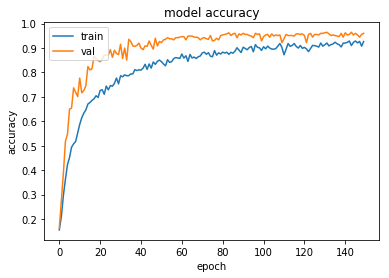

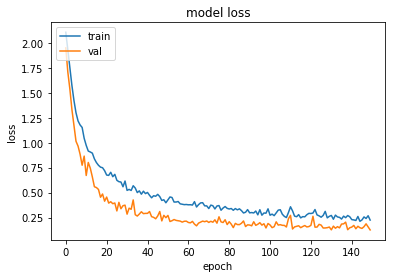

In [6]:
plot_history(history, save=True, path='nets/cnn_net/', name='cnn_all_classes')

### Not trained on catfood_beef
* Catfood beef and catfood salmon is in some picture identical so it is not possible to differentiate between the two classes, thus a model is trained without catfood beef

In [7]:
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'
train_generator, test_generator = make_data_generator(train_path, test_path, load_ram=False, ignore=['catfood_beef'])

Found 1641 images belonging to 7 classes.
Found 413 images belonging to 7 classes.


In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(7))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

In [9]:
# Checkpoint to save best model
file_path = 'saved_models/cnn_without_catbeef.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [10]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1641 // batch_size,
            epochs=150,
            validation_data=test_generator,
            validation_steps=413 // batch_size,
            use_multiprocessing=True,
            workers=4,
            callbacks=callback_list)

Epoch 1/150
51/51 [==============================] - 24s 466ms/step - loss: 1.9761 - acc: 0.1934 - val_loss: 1.7241 - val_acc: 0.2109

Epoch 00001: val_acc improved from -inf to 0.21094, saving model to saved_models/cnn_without_catbeef.e01-a0.21.hdf5
Epoch 2/150
51/51 [==============================] - 24s 477ms/step - loss: 1.6841 - acc: 0.2623 - val_loss: 1.5397 - val_acc: 0.2969

Epoch 00002: val_acc improved from 0.21094 to 0.29688, saving model to saved_models/cnn_without_catbeef.e02-a0.30.hdf5
Epoch 3/150
51/51 [==============================] - 27s 527ms/step - loss: 1.5334 - acc: 0.3432 - val_loss: 1.3417 - val_acc: 0.5365

Epoch 00003: val_acc improved from 0.29688 to 0.53646, saving model to saved_models/cnn_without_catbeef.e03-a0.54.hdf5
Epoch 4/150
51/51 [==============================] - 25s 495ms/step - loss: 1.3403 - acc: 0.4422 - val_loss: 1.1025 - val_acc: 0.5859

Epoch 00004: val_acc improved from 0.53646 to 0.58594, saving model to saved_models/cnn_without_catbeef.e0

51/51 [==============================] - 25s 483ms/step - loss: 0.3426 - acc: 0.8906 - val_loss: 0.2016 - val_acc: 0.9635

Epoch 00040: val_acc improved from 0.96094 to 0.96354, saving model to saved_models/cnn_without_catbeef.e40-a0.96.hdf5
Epoch 41/150
51/51 [==============================] - 26s 511ms/step - loss: 0.2799 - acc: 0.9007 - val_loss: 0.1971 - val_acc: 0.9688

Epoch 00041: val_acc improved from 0.96354 to 0.96875, saving model to saved_models/cnn_without_catbeef.e41-a0.97.hdf5
Epoch 42/150
51/51 [==============================] - 27s 527ms/step - loss: 0.2995 - acc: 0.8979 - val_loss: 0.1727 - val_acc: 0.9714

Epoch 00042: val_acc improved from 0.96875 to 0.97135, saving model to saved_models/cnn_without_catbeef.e42-a0.97.hdf5
Epoch 43/150
51/51 [==============================] - 27s 521ms/step - loss: 0.3185 - acc: 0.8976 - val_loss: 0.1695 - val_acc: 0.9661

Epoch 00043: val_acc did not improve from 0.97135
Epoch 44/150
51/51 [==============================] - 27s 535m

51/51 [==============================] - 25s 500ms/step - loss: 0.1758 - acc: 0.9396 - val_loss: 0.1521 - val_acc: 0.9792

Epoch 00082: val_acc did not improve from 0.98438
Epoch 83/150
51/51 [==============================] - 25s 483ms/step - loss: 0.2210 - acc: 0.9228 - val_loss: 0.1781 - val_acc: 0.9714

Epoch 00083: val_acc did not improve from 0.98438
Epoch 84/150
51/51 [==============================] - 25s 495ms/step - loss: 0.2106 - acc: 0.9335 - val_loss: 0.1808 - val_acc: 0.9766

Epoch 00084: val_acc did not improve from 0.98438
Epoch 85/150
51/51 [==============================] - 25s 496ms/step - loss: 0.1709 - acc: 0.9461 - val_loss: 0.1856 - val_acc: 0.9792

Epoch 00085: val_acc did not improve from 0.98438
Epoch 86/150
51/51 [==============================] - 25s 491ms/step - loss: 0.1927 - acc: 0.9405 - val_loss: 0.1741 - val_acc: 0.9740

Epoch 00086: val_acc did not improve from 0.98438
Epoch 87/150
51/51 [==============================] - 25s 490ms/step - loss: 0.1929

51/51 [==============================] - 27s 529ms/step - loss: 0.1553 - acc: 0.9531 - val_loss: 0.1291 - val_acc: 0.9792

Epoch 00126: val_acc did not improve from 0.98438
Epoch 127/150
51/51 [==============================] - 24s 478ms/step - loss: 0.1253 - acc: 0.9632 - val_loss: 0.1554 - val_acc: 0.9740

Epoch 00127: val_acc did not improve from 0.98438
Epoch 128/150
51/51 [==============================] - 26s 504ms/step - loss: 0.1425 - acc: 0.9553 - val_loss: 0.1496 - val_acc: 0.9818

Epoch 00128: val_acc did not improve from 0.98438
Epoch 129/150
51/51 [==============================] - 27s 523ms/step - loss: 0.1409 - acc: 0.9601 - val_loss: 0.1228 - val_acc: 0.9818

Epoch 00129: val_acc did not improve from 0.98438
Epoch 130/150
51/51 [==============================] - 25s 490ms/step - loss: 0.1483 - acc: 0.9540 - val_loss: 0.1362 - val_acc: 0.9792

Epoch 00130: val_acc did not improve from 0.98438
Epoch 131/150
51/51 [==============================] - 25s 490ms/step - loss: 0

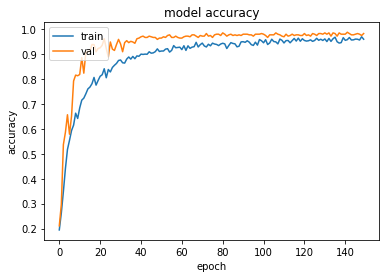

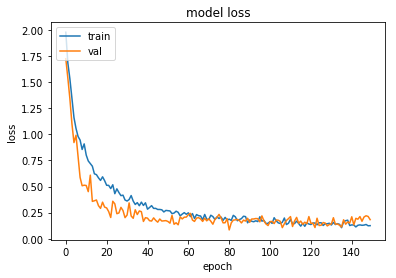

In [11]:
plot_history(history, save=True, path='nets/cnn_net/', name='cnn_without_catbeef')

The above training on all classes and training without catfood beef is summurized below:

|Summarize             | Epoch | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy |
|:--------------------:|:-----:|:-------------:|:-----------------:|:---------------:|:-------------------:|
| All Classes          |  132  |     0.2338    |      0.9201       |      0.1640     |        0.9643       |
| Without catfood beef |  142  |     0.1298    |      0.9577       |      0.1330     |        0.9870       |

The results is the best achieved validation accuracy with the respectivly training accuracy. 

From the results it can be conluded that without the catfood beef the model is performing better. 

Forskellen mellem accuracy stemmer overens at de billeder af dåserne fra begge kattemad ligner hinanden er væk.

In [5]:
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'
train_generator_ram, test_generator_ram = make_data_generator(train_path, test_path, load_ram=True)
train_generator_not_ram, test_generator_not_ram = make_data_generator(train_path, test_path, load_ram=False)

Found Training 1875 images belonging to 8 classes
Found Test 472 images belonging to 8 classes
Found 1875 images belonging to 8 classes.
Found 472 images belonging to 8 classes.


In [3]:
train_generator_ram.next()

(array([[[[-0.09704576, -0.0543268 ,  0.05488941],
          [-0.08642929, -0.05894484,  0.07511007],
          [-0.08003765, -0.06052184,  0.08355974],
          ...,
          [ 0.15898564,  0.12381491,  0.06002824],
          [ 0.15051295,  0.11411452,  0.05257412],
          [ 0.16831583,  0.13107452,  0.06342274]],
 
         [[-0.09730302, -0.05294849,  0.05500863],
          [-0.08083242, -0.05060183,  0.0688272 ],
          [-0.06534275, -0.04707138,  0.0781553 ],
          ...,
          [ 0.14561047,  0.10404602,  0.06146092],
          [ 0.14930615,  0.11115922,  0.06730458],
          [ 0.13866459,  0.10172237,  0.05615687]],
 
         [[-0.09877125, -0.05187974,  0.05675504],
          [-0.08605491, -0.05189019,  0.04609046],
          [-0.05967687, -0.04048523,  0.05796602],
          ...,
          [ 0.12723243,  0.08666562,  0.04619085],
          [ 0.13568836,  0.10202982,  0.056     ],
          [ 0.12175687,  0.08359949,  0.02840053]],
 
         ...,
 
         [[-

In [4]:
train_generator_not_ram.next()

(array([[[[ 2.63738573e-01,  2.63320267e-01,  4.15673733e-01],
          [ 2.50825644e-01,  2.54780680e-01,  4.24129695e-01],
          [ 2.45452568e-01,  2.49282107e-01,  4.24736232e-01],
          ...,
          [ 4.45260167e-01,  3.66952181e-01,  4.09047902e-01],
          [ 4.32865888e-01,  3.65094900e-01,  4.09436911e-01],
          [ 4.50668782e-01,  3.82054895e-01,  4.28128660e-01]],
 
         [[ 2.59559751e-01,  2.64698595e-01,  4.19714540e-01],
          [ 2.56422490e-01,  2.63123691e-01,  4.21768397e-01],
          [ 2.56225914e-01,  2.62732536e-01,  4.19331759e-01],
          ...,
          [ 4.43649709e-01,  3.66791159e-01,  4.10480529e-01],
          [ 4.47345376e-01,  3.85669023e-01,  4.28088903e-01],
          [ 4.44546968e-01,  3.76232177e-01,  4.28705901e-01]],
 
         [[ 2.69856215e-01,  2.65767336e-01,  4.05774653e-01],
          [ 2.70807862e-01,  2.65756905e-01,  4.06874806e-01],
          [ 2.69734889e-01,  2.69318730e-01,  4.06985641e-01],
          ...,
    

In [6]:
history_ram = model.fit_generator(
            train_generator_ram,
            steps_per_epoch=1875 // batch_size,
            epochs=100,
            validation_data=test_generator_ram,
            validation_steps=472 // batch_size,
            workers=2)
history_not_ram = model.fit_generator(
            train_generator_not_ram,
            steps_per_epoch=1875 // batch_size,
            epochs=100,
            validation_data=test_generator_not_ram,
            validation_steps=472 // batch_size,
            workers=2)

Epoch 1/100
58/58 [==============================] - 12s 213ms/step - loss: 2.3971 - acc: 0.0641 - val_loss: 2.0778 - val_acc: 0.1674
Epoch 2/100
58/58 [==============================] - 12s 201ms/step - loss: 2.0927 - acc: 0.1412 - val_loss: 2.0304 - val_acc: 0.2210
Epoch 3/100
58/58 [==============================] - 12s 202ms/step - loss: 1.9903 - acc: 0.1870 - val_loss: 1.8147 - val_acc: 0.2478
Epoch 4/100
58/58 [==============================] - 11s 195ms/step - loss: 1.9246 - acc: 0.2231 - val_loss: 1.7493 - val_acc: 0.4754
Epoch 5/100
58/58 [==============================] - 12s 206ms/step - loss: 1.8202 - acc: 0.2729 - val_loss: 1.6684 - val_acc: 0.3527
Epoch 6/100
58/58 [==============================] - 12s 206ms/step - loss: 1.7543 - acc: 0.2815 - val_loss: 1.5218 - val_acc: 0.4152
Epoch 7/100
58/58 [==============================] - 12s 210ms/step - loss: 1.6516 - acc: 0.3140 - val_loss: 1.5370 - val_acc: 0.4062
Epoch 8/100
58/58 [==============================] - 12s 210ms

Epoch 62/100
58/58 [==============================] - 11s 196ms/step - loss: 0.6344 - acc: 0.7218 - val_loss: 0.4024 - val_acc: 0.8527
Epoch 63/100
58/58 [==============================] - 11s 197ms/step - loss: 0.6464 - acc: 0.7244 - val_loss: 0.5742 - val_acc: 0.7902
Epoch 64/100
58/58 [==============================] - 11s 198ms/step - loss: 0.8616 - acc: 0.6689 - val_loss: 0.6148 - val_acc: 0.8393
Epoch 65/100
58/58 [==============================] - 12s 205ms/step - loss: 0.8332 - acc: 0.6514 - val_loss: 0.7494 - val_acc: 0.7500
Epoch 66/100
58/58 [==============================] - 12s 199ms/step - loss: 0.7167 - acc: 0.7082 - val_loss: 0.5221 - val_acc: 0.8438
Epoch 67/100
58/58 [==============================] - 12s 205ms/step - loss: 0.6499 - acc: 0.7164 - val_loss: 0.4839 - val_acc: 0.8638
Epoch 68/100
58/58 [==============================] - 12s 200ms/step - loss: 0.6442 - acc: 0.7210 - val_loss: 0.4675 - val_acc: 0.8616
Epoch 69/100
58/58 [==============================] - 1

KeyboardInterrupt: 

In [ ]:
plot_history(history_ram)
plot_history(history_not_ram)

### Calculate mean for each channel

In [2]:
import util.image_import as ii
mean = ii.calulate_mean('../dataset3/res_still/train', [])

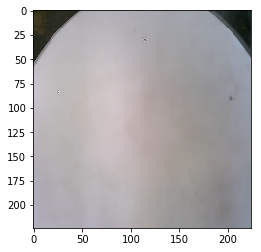

In [13]:
plt.imshow(mean.astype(np.uint8))

In [21]:
mean = np.asarray(mean)
mean=mean.reshape(-1, mean.shape[-1]).mean(0) 
print(mean)

[166.44579 162.67743 164.90118]
